In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import functools

from collections import Counter 

%matplotlib inline

In [3]:
# Load social network from adjacency matrix
df = pd.read_excel("./data/network.xlsx", index_col = 0)

# generate to binary map
binary_df = df 
binary_df[binary_df != 0] = 1

# df_info = df.describe().loc[['min', 'max','mean']].astype(int)
adjacency = df.values
adjacency_binary = binary_df.values

In [139]:
# Get networkx Graph and related attribute for later usage
G_dir = nx.from_numpy_matrix(adjacency.astype('int32'), create_using=nx.DiGraph)
G = nx.from_numpy_matrix(adjacency.astype('int32'))


# Get all social network Centralities data
degree = nx.degree(G)
in_degree = G_dir.in_degree()
closeness = nx.closeness_centrality(G)

betweeness = nx.betweenness_centrality(G, normalized=True, endpoints=True)

# transform data type to list tuple
in_degree = [(k, v) for k, v in in_degree]
closeness = [(k, v) for k, v in closeness.items()]
betweeness =  [(k, v) for k, v in betweeness.items()]

# 1. Network structure

## 1.1 - Visualization

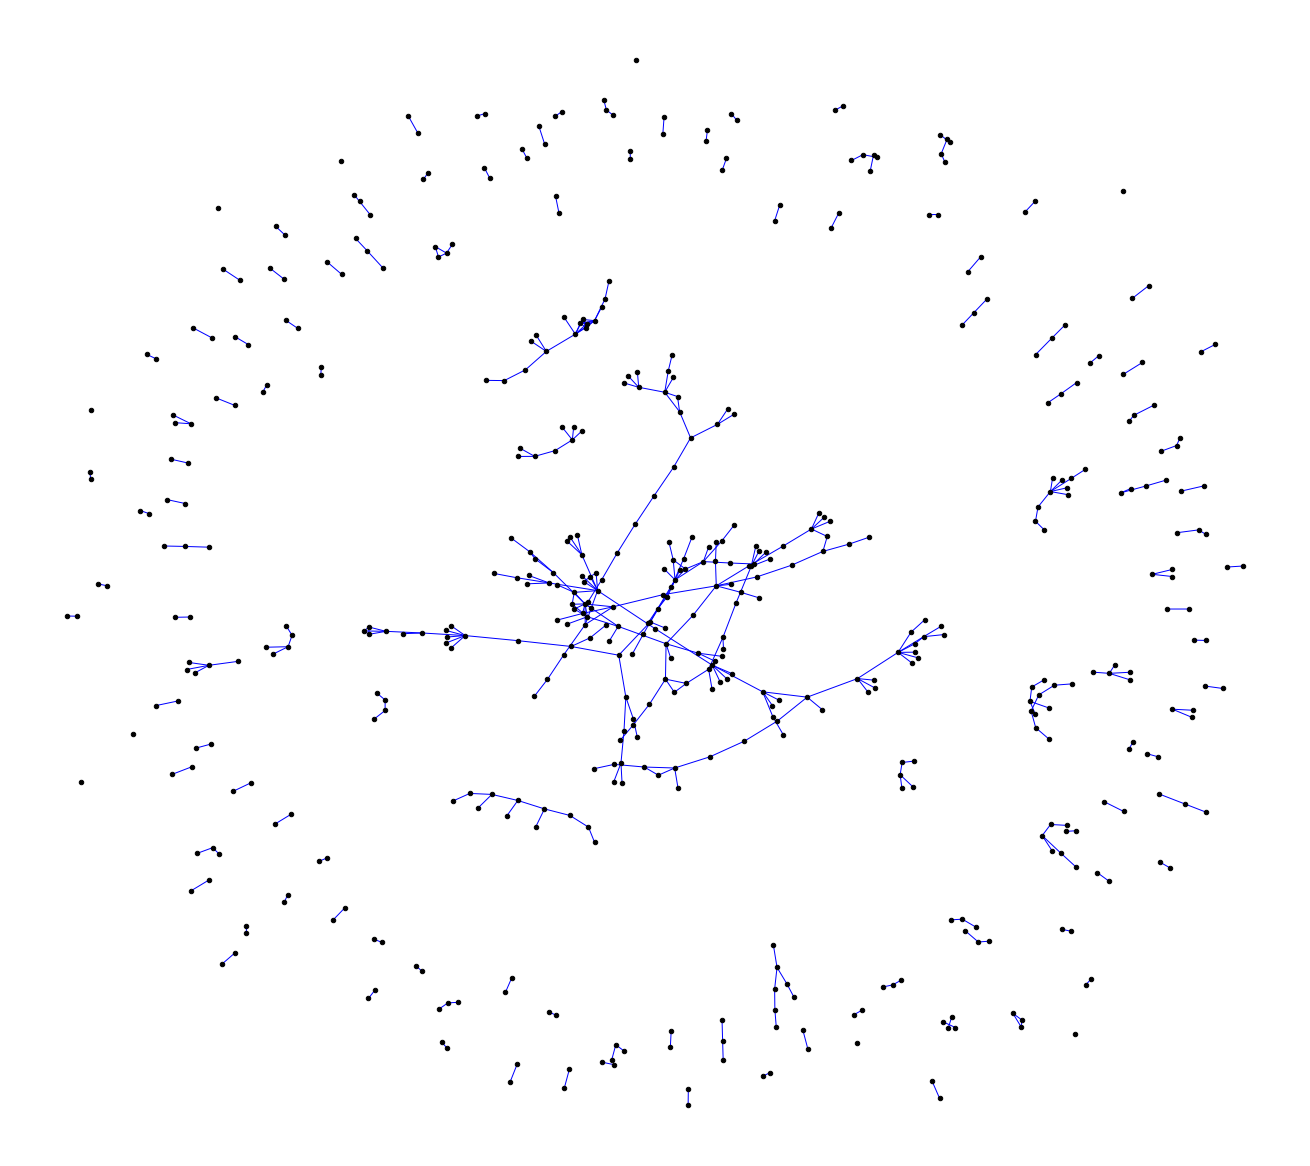

In [140]:
plt.figure(figsize=(18, 16))
nx.draw(G, node_size=20, node_color="black", edge_color="b", width=1)

# plt.savefig('./data/Alibaba-network.png')

## 1.2 - Structure description

### 1.2.1 - Network density
The ratio of actual edges in the network to all possible edges in the network

In [17]:
density = nx.density(G)
density

0.0031024307183930852

### 1.2.2 - Degree
The number of connections that a node has

In [18]:
degree_df = pd.DataFrame(list(dict(degree).values()), columns=['degree'])
degree_df.describe()

,degree
count,527.000000
mean,1.631879
std,1.250539
min,0.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,10.000000


In [19]:
# Print degree summary
degree_count = Counter(dict(degree).values())

for key in sorted(degree_count.keys(), reverse=True) :
    print(f'Number of people have {key} degree is: {degree_count[key]}')

Number of people have 10 degree is: 1
Number of people have 9 degree is: 1
Number of people have 7 degree is: 6
Number of people have 6 degree is: 3
Number of people have 5 degree is: 11
Number of people have 4 degree is: 18
Number of people have 3 degree is: 37
Number of people have 2 degree is: 102
Number of people have 1 degree is: 339
Number of people have 0 degree is: 9


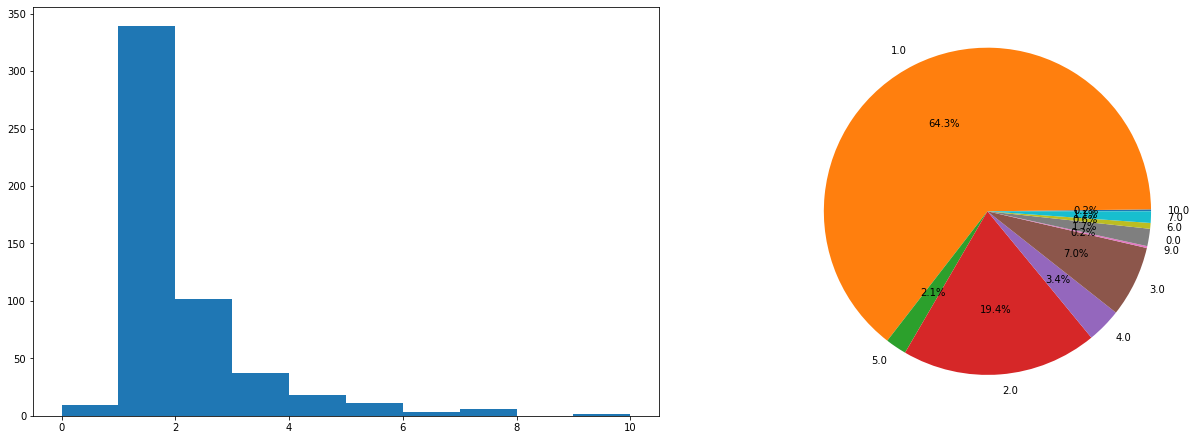

In [20]:
Degree_summary, (degree_hist, degree_pie) = plt.subplots(ncols=2, constrained_layout=True, figsize=(18, 6))
pie = degree_pie.pie(
    [float(v) for v in degree_count.values()], 
    labels=[float(k) for k in degree_count], autopct='%1.1f%%',)
hist = degree_hist.hist(dict(degree).values(), 10)

### 1.2.3 - Closeness

In [21]:
closeness_df = pd.DataFrame(list(dict(closeness).values()), columns=['closeness'])
closeness_df.describe()

,closeness
count,527.000000
mean,0.009588
std,0.010812
min,0.000000
25%,0.001901
50%,0.003802
75%,0.012139
max,0.041598


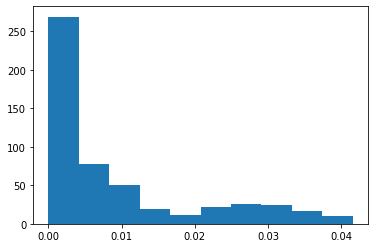

In [22]:
hist = plt.hist(dict(closeness).values(), 10)

# Indicate lots of "subset" network structure

### 1.2.4 - Betweeness

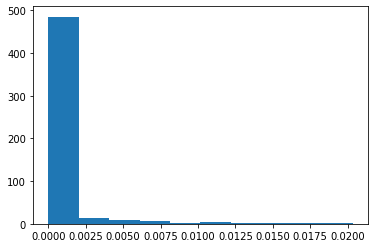

In [173]:
betweeness_df = pd.DataFrame(list(dict(betweeness).values()), columns=['betweeness'])
betweeness_df.describe()
hist_betweeness = plt.hist(dict(betweeness).values(), 10)

# 2. Identify KOL

## 2.1 - Rank of degree, closeness ,and betweeness

In [24]:
def compose(*functions):
    return functools.reduce(lambda f, g: lambda x: f(g(x)), functions, lambda x: x)

def sort_centrality(graphView_tuple_list, descend=True) -> list:
    result = sorted(graphView_tuple_list, key=lambda x: x[1], reverse = descend)
    return result

def get_rank(rank: str) -> list:
    return lambda graphView_tuple_list: [(item[0], item[1]) for item in graphView_tuple_list[:rank]]

def list_str(user_list: list) -> str:
    return ', '.join(user_list)

def extract_user_num(graphView_tuple_list)-> list:
    return [str(item[0]+1) for item in graphView_tuple_list]

def transform_index_to_user(user_tuple_list: list) -> list:
    return [(item[0]+1, item[1]) for item in user_tuple_list]

def select_user(user_list) -> list:
    return lambda graphView_tuple_list: [v for i, v in enumerate(graphView_tuple_list) if str(v[0]+1) in list(user_list)]

def transform_tuplelist_to_dict(tuple_list) -> dict:
    return dict((x, y) for x, y in tuple_list)

In [25]:
get_top_10_user = compose(transform_tuplelist_to_dict, transform_index_to_user, get_rank(10), sort_centrality)

### 2.1.1 - Top 10 degree users

In [26]:
pd.DataFrame.from_dict(get_top_10_user(degree), orient='index', columns=['degree'])

,degree
1,10
78,9
187,7
293,7
343,7
362,7
498,7
521,7
162,6
284,6


### 2.1.1.1 -  Top 10 indegree users

In [40]:
pd.DataFrame.from_dict(get_top_10_user(in_degree), orient='index', columns=['in_degree'])

,in_degree
1,10
78,9
187,7
293,7
362,7
521,7
162,6
284,6
498,6
74,5


(array([ 11., 343., 101.,  34.,  19.,  10.,   3.,   4.,   0.,   2.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <a list of 10 Patch objects>)

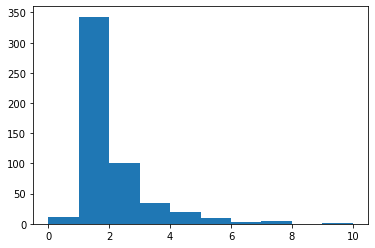

In [41]:
# indegree hist
indegree_hist = plt.hist(dict(in_degree).values(), 10)
indegree_hist

### 2.1.2 - Top 10 clossness users

In [42]:
pd.DataFrame.from_dict(get_top_10_user(closeness), orient='index', columns=['clossness'])

,clossness
4,0.041598
162,0.040358
303,0.040076
29,0.039525
1,0.039458
127,0.039056
92,0.038989
57,0.038858
78,0.038792
277,0.037773


### 2.1.3 - Top 10 betweeness users

In [43]:
pd.DataFrame.from_dict(get_top_10_user(betweeness), orient='index', columns=['clossness'])

,clossness
162,0.020331
4,0.019153
311,0.018499
461,0.016760
78,0.015345
293,0.012991
1,0.012050
303,0.011888
29,0.011421
198,0.011335


### 2.1.4 - Top 10 users summary

In [44]:
get_top_10_user = compose(extract_user_num, get_rank(10), sort_centrality)


top_10_degree_user = get_top_10_user(degree)
top_10_closeness_user = get_top_10_user(closeness)
top_10_betweeness_user = get_top_10_user(betweeness)


print('Top 10 degree users: ' + list_str(top_10_degree_user))
print('Top 10 closeness users: ' + list_str(top_10_closeness_user))
print('Top 10 betweeness users: ' + list_str(top_10_betweeness_user))

Top 10 degree users: 1, 78, 187, 293, 343, 362, 498, 521, 162, 284
Top 10 closeness users: 4, 162, 303, 29, 1, 127, 92, 57, 78, 277
Top 10 betweeness users: 162, 4, 311, 461, 78, 293, 1, 303, 29, 198


## 2.3 - Elite group

In [45]:
elite_group = set(top_10_degree_user + top_10_closeness_user + top_10_betweeness_user)
print('Elite group users: ' + ", ".join(elite_group))

Elite group users: 92, 343, 187, 127, 57, 303, 498, 29, 521, 1, 277, 198, 293, 4, 461, 162, 362, 311, 78, 284


In [46]:
def label_user(tuple_list) -> list:
    return [(str(item[0]+1), item[1]) for item in tuple_list]

def summary_df(column_name = [1, 2, 3], *group_dict):
    result = pd.DataFrame()
    for each_dict in group_dict:
        each_df = pd.DataFrame.from_dict(each_dict, orient='index')
        result = pd.concat([result, each_df], axis=1)
    
    result.columns = column_name
    
    return result

get_Elite_group = compose(transform_tuplelist_to_dict, label_user, select_user(elite_group))

Elite_group_degree = get_Elite_group(degree)
Elite_group_closeness = get_Elite_group(closeness)
Elite_group_betweeness = get_Elite_group(betweeness)

top_10_elite_group = summary_df(['degree', 'closeness', 'betweeness'], Elite_group_degree, Elite_group_closeness, Elite_group_betweeness)
top_10_elite_group

,degree,closeness,betweeness
1,10,0.039458,0.012050
4,5,0.041598,0.019153
29,2,0.039525,0.011421
57,4,0.038858,0.006700
78,9,0.038792,0.015345
92,4,0.038989,0.005720
127,3,0.039056,0.006548
162,6,0.040358,0.020331
187,7,0.026874,0.007561
198,4,0.036398,0.011335


### 2.3.1 - Elite group centrality metrics (base on population mean)
Calculate if each users has Degree, Cloness, Betwness that higher or lower than the population mean.
True means higher than average. Falase means lower than average.

In [47]:
# Get the mean of population
degree_mean = degree_df['degree'].mean()
closeness_mean = closeness_df['closeness'].mean()
betweeness_mean = betweeness_df['betweeness'].mean()

# create feature map base on the population
filter_map = np.tile(np.array([degree_mean, closeness_mean, betweeness_mean]), (top_10_elite_group.shape[0], 1))


# Mask the elite group base to get category
result = top_10_elite_group.values > filter_map

centrality_cat_base_on_population = pd.DataFrame(data=result, 
                                                 index=top_10_elite_group.index.values, 
                                                 columns=['degree', 'closeness', 'betweeness'])
centrality_cat_base_on_population

,degree,closeness,betweeness
1,True,True,True
4,True,True,True
29,True,True,True
57,True,True,True
78,True,True,True
92,True,True,True
127,True,True,True
162,True,True,True
187,True,True,True
198,True,True,True


### 2.3.2 - Elite group centrality metrics (base on Elite group mean)
Calculate if each users has Degree, Cloness, Betwness that higher or lower than the elite group mean.

In [48]:
# Get the mean of population
elit_degree_mean = top_10_elite_group['degree'].mean()
elit_closeness_mean = top_10_elite_group['closeness'].mean()
elit_betweeness_mean = top_10_elite_group['betweeness'].mean()

# create feature map base on the population
elite_filter_map = np.tile(np.array([elit_degree_mean, elit_closeness_mean, elit_betweeness_mean]), (top_10_elite_group.shape[0], 1))


# Mask the elite group base to get category
elite_result = top_10_elite_group.values > elite_filter_map

centrality_cat_base_on_elite_group = pd.DataFrame(data=elite_result, 
                                                 index=top_10_elite_group.index.values, 
                                                 columns=['degree', 'closeness', 'betweeness'])
centrality_cat_base_on_elite_group


,degree,closeness,betweeness
1,True,True,True
4,False,True,True
29,False,True,True
57,False,True,False
78,True,True,True
92,False,True,False
127,False,True,False
162,True,True,True
187,True,False,False
198,False,True,True


### 2.3.3 - Get Elite group category base on difference high, low centralities


In [49]:
def extract_user(df) -> list:
    return list(df.index.values)

def filter_rule(centrality_name: str):
    return lambda criteria : lambda df: df[df[centrality_name] == criteria]


high_degree_low_closeness = compose(list_str, extract_user, filter_rule('closeness')(False), filter_rule('degree')(True))
high_degree_low_betweeness = compose(list_str, extract_user, filter_rule('betweeness')(False), filter_rule('degree')(True))
low_degree_high_closeness = compose(list_str, extract_user, filter_rule('closeness')(True), filter_rule('degree')(False))
low_betweeness_high_closeness = compose(list_str, extract_user, filter_rule('betweeness')(False), filter_rule('closeness')(True))


In [50]:
print('High Degree, Low closeness Users: ' + high_degree_low_closeness(centrality_cat_base_on_elite_group))
print('High Degree, Low Betweeness Users: ' + high_degree_low_betweeness(centrality_cat_base_on_elite_group))
print('Low Degree, High closeness Users: ' + low_degree_high_closeness(centrality_cat_base_on_elite_group))
print('Low Betweeness Users, High closeness Users: ' + low_betweeness_high_closeness(centrality_cat_base_on_elite_group))

High Degree, Low closeness Users: 187, 284, 343, 362, 498, 521
High Degree, Low Betweeness Users: 187, 284, 343, 362, 498, 521
Low Degree, High closeness Users: 4, 29, 57, 92, 127, 198, 277, 303, 311, 461
Low Betweeness Users, High closeness Users: 57, 92, 127, 277


# 3. Subgraph
- Subgraph analysis 
- Triadic analysis

## 3.1 - Subgraph

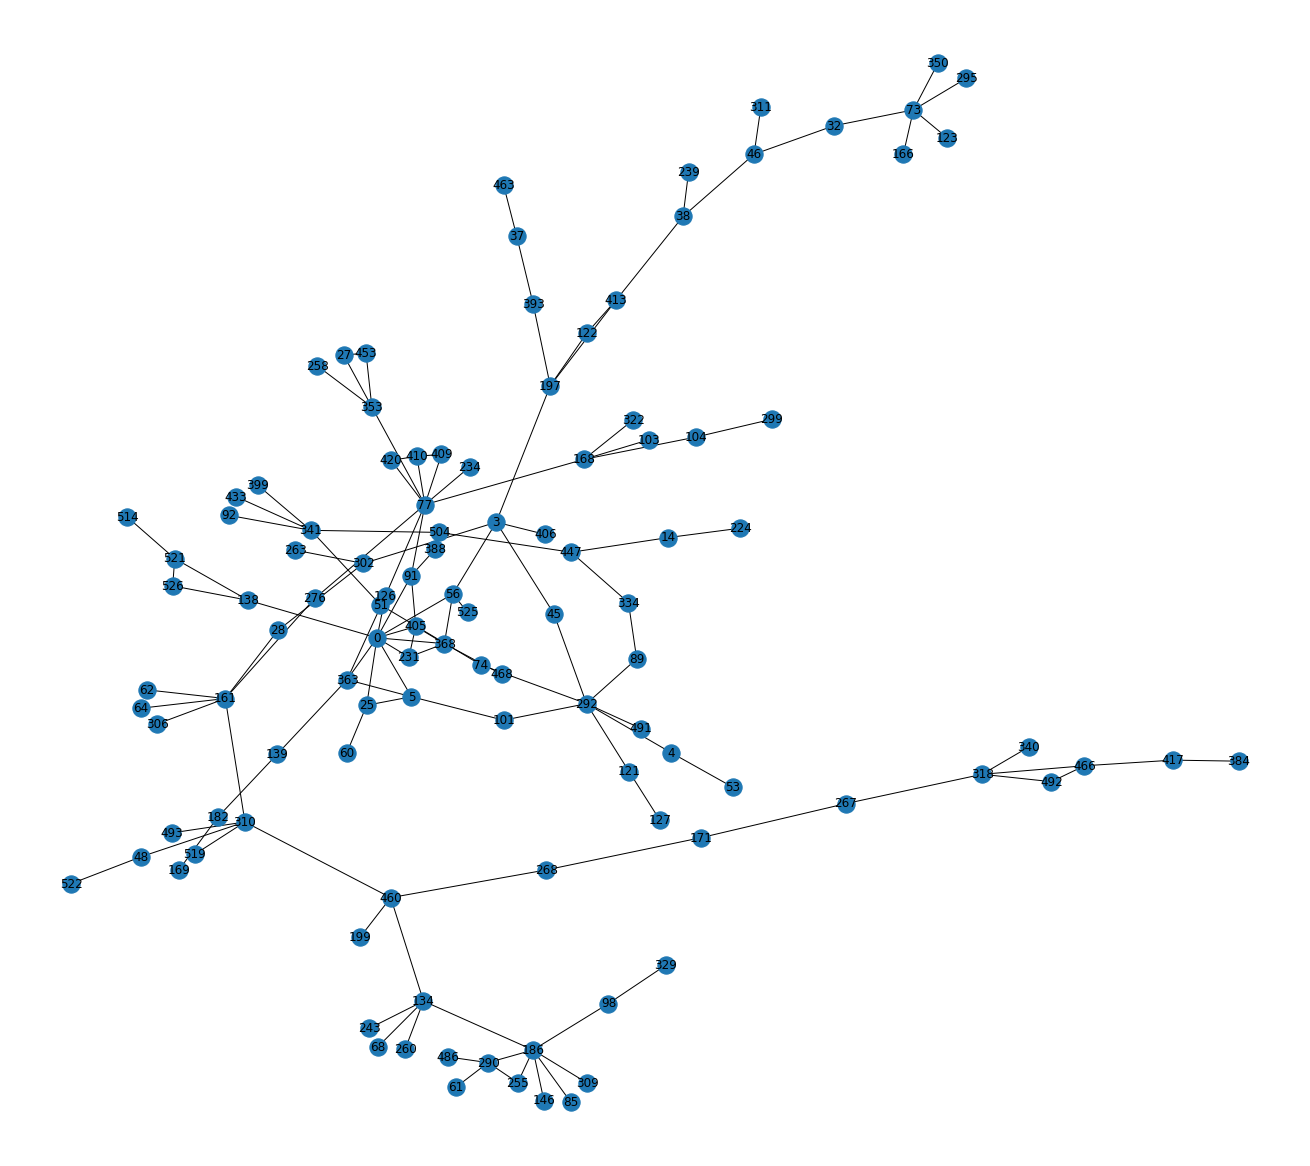

In [165]:
largest_connect_component = [c for c in sorted(nx.connected_components(G), key=len, reverse=True)][0]
LCC = G.subgraph(list(largest_connect_component))

plt.figure(figsize=(18, 16))
nx.draw(LCC, edge_color="black", width=1, with_labels=True)

## 3.1.1 - Ego graph analysis

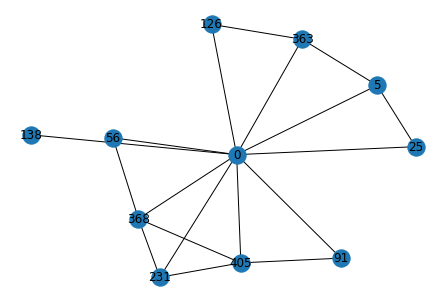

In [177]:
user_1_G = nx.ego_graph(G, 0, radius=1)
nx.draw(user_1_G,edge_color="black", width=1, with_labels = True)

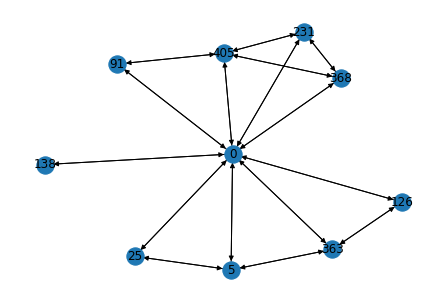

In [178]:
# Show user 1 graph with directories 
user_1_G = nx.ego_graph(G_dir, 0, radius=1)
nx.draw(user_1_G,edge_color="black", width=1, with_labels = True)

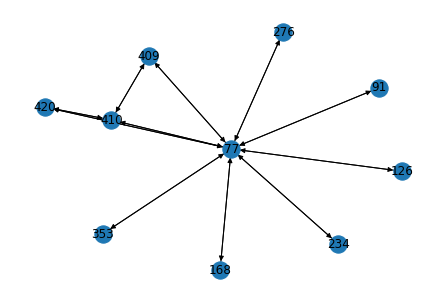

In [179]:
user_78_G = nx.ego_graph(G_dir, 77, radius=1)
nx.draw(user_78_G,edge_color="black", width=1, with_labels = True)

## 3.1.2- Ego graph cluster cofficient
#### Decribe the reach of the information a person can transmit
Definition: The proportion of your friends that are also friends with each other. Dense ego networks with a lot of mutual trust have a high clustering coefficient. Star networks with a single broadcast node and passive listeners have a low clustering coefficient.

- User 78 is more like a pure broadcaster than user 1 who is in a 'trust' network ( p.s. A trust network is a network that people link to each other, have more edge between nodes )

In [181]:
user_1_G_len = len(nx.Graph(user_1_G))
user_1_G_cluster_cof = nx.average_clustering(nx.Graph(user_1_G))


user_78_G_len = len(nx.Graph(user_78_G))
user_78_G_cluster_cof = nx.average_clustering(nx.Graph(user_78_G))


print('The len of user 1 network is: ' + str(user_1_G_len))
print('The len of user 78 network is: ' + str(user_78_G_len))
print('---')
print('The Cluster cofficient of user 1 network is: ' + str(user_1_G_cluster_cof))
print('The Cluster cofficient of user 78 network is: ' + str(user_78_G_cluster_cof))

The len of user 1 network is: 10
The len of user 78 network is: 10
---
The Cluster cofficient of user 1 network is: 0.7194444444444444
The Cluster cofficient of user 78 network is: 0.2722222222222222


## 3.2 - Triads analysis

Structure Hole: an actor provides the only connection between other two actors. In tradic analysis, "201" means structure hole. (http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.210.1168&rep=rep1&type=pdf)

Cliques: A group of people that tightly connect together. A maximal complete subgraph of a given graph. For example, a group of people where everybody is connected directly to everyone else

Benefit:
- Access to information, knowledge, and resources that are not universally held and 
- The ability to play actors, or groups of actors, off against each other in the competition for resources.
- The ratio between structural hole(201) and closed triads(300) is also important—a hierarchy is largely composed of structural holes, while more egalitarian structures would have a higher ratio of closed triads.



In [237]:
macro_triads_summary = nx.triadic_census(G_dir)

pd.DataFrame.from_dict(macro_triads_summary, orient='index',
                       columns=['Triad Summary'])

,Triad Summary
003,24030576
012,10928
102,213091
021D,1
021U,0
021C,5
111D,41
111U,23
030T,1
030C,0


In [238]:
# Get every node
def get_nodes_triad_summary(direct_graph):
    each_triads_summary = {}
    for el in direct_graph.nodes(data=True):
        cc = [c for c in nx.node_connected_component(G, el[0])]
        cc_G = direct_graph.subgraph(list(cc))
        el_triads_summary = nx.triadic_census(cc_G)
        
        each_triads_summary[el[0]] = el_triads_summary
    return each_triads_summary

def format_nodes_tradics_summary_to_df(nodes_triads_summary):
    result = {}
    for i, node_name in enumerate(nodes_triads_summary):
        if i == 0:
            column_name = list(nodes_triads_summary[node_name].keys())
        result[node_name+1] = nodes_triads_summary[node_name].values()
    return column_name, result
    
nodes_triads_summary = get_nodes_triad_summary(G_dir)
column_name, nodes_triads_summary_dict = format_nodes_tradics_summary_to_df(nodes_triads_summary)
nodes_triads_summary_df = pd.DataFrame.from_dict(nodes_triads_summary_dict, orient='index', columns=column_name)

nodes_triads_summary_df

,003,012,102,021D,021U,021C,111D,111U,030T,030C,201,120D,120U,120C,210,300
1,208070,836,12609,0,0,2,20,8,1,0,254,0,0,0,1,14
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,208070,836,12609,0,0,2,20,8,1,0,254,0,0,0,1,14
5,208070,836,12609,0,0,2,20,8,1,0,254,0,0,0,1,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
523,208070,836,12609,0,0,2,20,8,1,0,254,0,0,0,1,14
524,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
525,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
526,208070,836,12609,0,0,2,20,8,1,0,254,0,0,0,1,14


In [239]:
nodes_triads_summary_df.describe()

,003,012,102,021D,021U,021C,111D,111U,030T,030C,201,120D,120U,120C,210,300
count,527.000000,527.000000,527.000000,527.000000,527.0,527.000000,527.000000,527.000000,527.000000,527.0,527.000000,527.0,527.000000,527.0,527.000000,527.000000
mean,44062.034156,180.688805,2722.550285,0.020873,0.0,0.527514,4.844402,2.132827,0.210626,0.0,59.481973,0.0,0.182163,0.0,0.339658,3.614801
std,84802.542338,339.043283,5114.727218,0.143095,0.0,0.819616,8.008935,3.201919,0.408141,0.0,101.227219,0.0,1.030442,0.0,0.767943,5.704512
min,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000
50%,2.000000,0.000000,2.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,4.000000,0.0,0.000000,0.0,0.000000,0.000000
75%,3222.000000,48.000000,736.000000,0.000000,0.0,1.000000,5.000000,3.000000,0.000000,0.0,43.000000,0.0,0.000000,0.0,0.000000,4.000000
max,208070.000000,836.000000,12609.000000,1.000000,0.0,2.000000,20.000000,8.000000,1.000000,0.0,254.000000,0.0,6.000000,0.0,4.000000,14.000000
